In [1]:
# 這個Jupyter Notebook的環境
import platform
import tensorflow
import keras
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython.display import Image

/home/dzw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Platform: Linux-4.13.0-38-generic-x86_64-with-debian-stretch-sid
Tensorflow version: 1.7.0
Keras version: 2.1.5


In [2]:
import os
import shutil

data_path = os.path.join('../data/train')

In [3]:
#训练所需数据的地址
def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))
train_dir = ['data','train']
test_dir = ['data', 'test']
valid_dir = ['data', 'valid']

mkdir_if_not_exist(train_dir)
mkdir_if_not_exist(test_dir)
mkdir_if_not_exist(valid_dir)

In [4]:
#在每个文件夹下创建dog cat 文件夹分类
for dir in os.listdir('data'):
    dog_dir = ['data',dir,'dog']
    cat_dir = ['data',dir,'cat']
    mkdir_if_not_exist(dog_dir)
    mkdir_if_not_exist(cat_dir)

In [5]:
# 实际未分类数据所在地址
all_data = '../data/train'

In [6]:
import os
import random
import shutil

def organize_folder(folder):
    _, _, filenames = next(os.walk(folder))
    unique_classes = {filename.split(".")[0] for filename in filenames}
    for _class in unique_classes:
        path = os.path.join(folder, _class)
        if not os.path.exists(path):
            os.makedirs(path)
        for filename in filenames:
            if filename.startswith(_class):
                shutil.move(os.path.join(folder, filename), os.path.join(path, filename))        
    
def create_sample_folder(_from, to, percentage=0.1, move=True):
    if not os.path.exists(to):
        os.makedirs(to)
    _, folders, _ = next(os.walk(_from))
    for folder in folders:
        if not os.path.exists(os.path.join(to, folder)):
            os.makedirs(os.path.join(to, folder))
        _, _, files = next(os.walk(os.path.join(_from, folder)))
        sample = random.sample(files, int(len(files) * percentage))
        for filename in sample:
            if move:
                shutil.move(os.path.join(_from, folder, filename), os.path.join(to, folder, filename))
            else:
                shutil.copyfile(os.path.join(_from, folder, filename), os.path.join(to, folder, filename))

In [7]:
organize_folder(all_data)

In [8]:
create_sample_folder(all_data, os.path.join(*train_dir))
create_sample_folder(all_data, os.path.join(*test_dir))
create_sample_folder(all_data, os.path.join(*valid_dir))

In [9]:
ls 'data' | head

test/
train/
valid/


In [10]:
ls 'data/train' | head

cat/
dog/


In [11]:
from keras.preprocessing.image import ImageDataGenerator

#归一化处理
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#keras 数据读取机制
train_gen = train_datagen.flow_from_directory(
    os.path.join(*train_dir),
    target_size=(150,150),
    batch_size=24,
    class_mode='binary'
)

valid_gen = test_datagen.flow_from_directory(
    os.path.join(*valid_dir),
    target_size=(150, 150),
    batch_size=24,
    class_mode='binary'
)

Found 4322 images belonging to 2 classes.
Found 3500 images belonging to 2 classes.


In [12]:
# 查看一次的输出
for data, label in train_gen:
    print('data batch shape:', data.shape)
    print('labels batch shape:', label.shape)
    break

data batch shape: (24, 150, 150, 3)
labels batch shape: (24,)


In [27]:
from keras.layers import *
from keras import models
from keras.utils import plot_model

model = models.Sequential()
model.add(Conv2D(32, (3,3), activation='relu',input_shape=(150,150,3)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

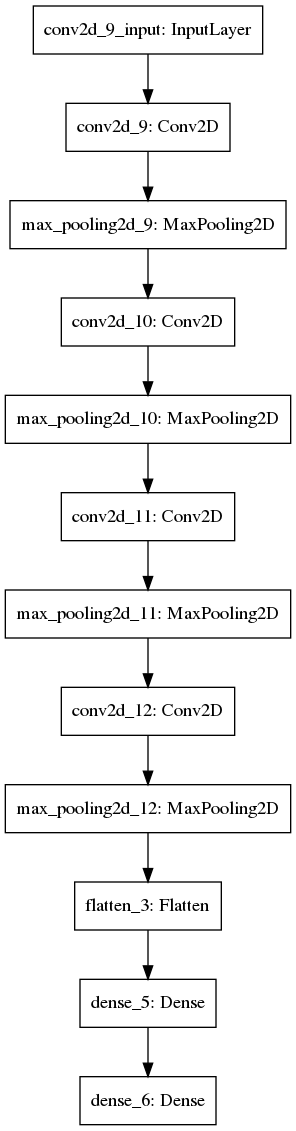

In [28]:
model.summary()
plot_model(model, to_file='cnn1.png')
Image('cnn1.png')

In [29]:
from keras import optimizers
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(1e-3),
    metrics=['acc',]
)

In [30]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=30,
    validation_data = valid_gen,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 7s 71ms/step - loss: 0.7627 - acc: 0.4950 - val_loss: 0.6909 - val_acc: 0.4908
Epoch 2/30
100/100 [==============================] - 7s 67ms/step - loss: 0.6935 - acc: 0.5633 - val_loss: 0.6701 - val_acc: 0.5933
Epoch 3/30
100/100 [==============================] - 7s 66ms/step - loss: 0.6820 - acc: 0.5925 - val_loss: 0.7097 - val_acc: 0.5842
Epoch 4/30
100/100 [==============================] - 7s 72ms/step - loss: 0.6352 - acc: 0.6500 - val_loss: 0.6118 - val_acc: 0.6642
Epoch 5/30
100/100 [==============================] - 7s 70ms/step - loss: 0.5945 - acc: 0.6908 - val_loss: 0.5683 - val_acc: 0.7133
Epoch 6/30
100/100 [==============================] - 7s 70ms/step - loss: 0.5579 - acc: 0.7087 - val_loss: 0.6267 - val_acc: 0.6917
Epoch 7/30
100/100 [==============================] - 7s 67ms/step - loss: 0.5647 - acc: 0.7204 - val_loss: 0.5787 - val_acc: 0.6950
Epoch 8/30
100/100 [==============================] - 7s 67ms/step - 

In [31]:
model.save('cat_vs_dog_1.h5')

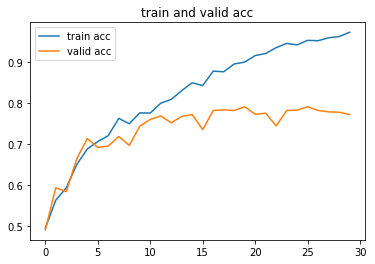

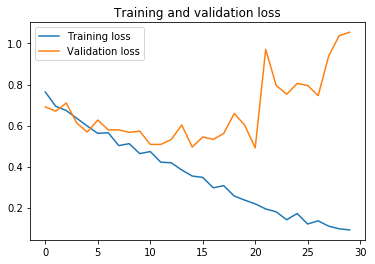

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, label='train acc')
plt.plot(epochs, val_acc, label='valid acc')
plt.title('train and valid acc')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
ation_dir

In [34]:
# 图像增强
datagen = ImageDataGenerator(
    rotation_range=90, #最大随即旋转90度
    width_shift_range=0.3,
    height_shift_range=0.3, #偏移量
    shear_range=0.3 ,#随即接切变换
    zoom_range=0.3, #随即放大图片内容
    horizontal_flip=True,
    fill_mode='nearest'
)

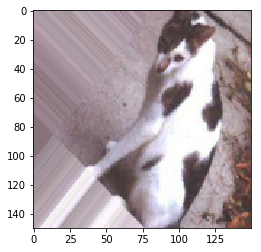

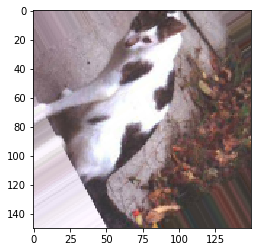

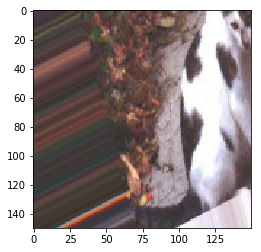

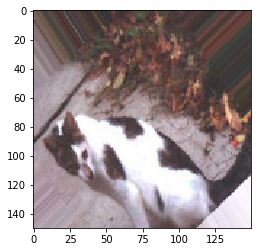

In [44]:
from keras.preprocessing import image
fname = [os.path.join(*train_dir,'cat',fname) for fname in os.listdir(os.path.join(*train_dir,'cat'))]
img = fname[0]
img = image.load_img(img, target_size=(150,150,3))
x = image.img_to_array(img)
x=x.reshape((1,*x.shape))
i = 0
for batch in datagen.flow(x, batch_size=1):#flow会随即产生新的图像,会无限循环
    plt.figure(i)
    implot = plt.imshow(image.array_to_img(batch[0]))
    i+=1
    if i%4==0:
        break
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 72, 72, 256)       295168    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 36, 36, 256)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 34, 34, 128)       295040    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 17, 17, 128)       0         
__________

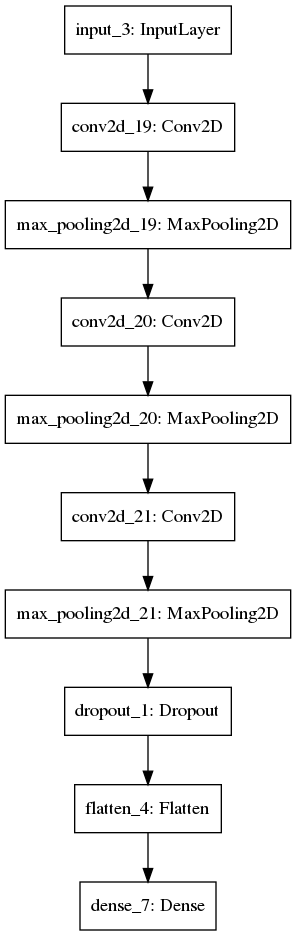

In [47]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.utils import plot_model

input = Input(shape=(150,150,3))
layer = Conv2D(128,kernel_size=3,activation='relu')(input)
layer = MaxPool2D((2,2))(layer)
layer = Conv2D(256,kernel_size=3,activation='relu')(layer)
layer = MaxPool2D((2,2))(layer)
layer = Conv2D(128,kernel_size=3,activation='relu')(layer)
layer = MaxPool2D((2,2))(layer)
layer = Dropout(0.5)(layer)

layer = Flatten()(layer)
output = Dense(1,activation='sigmoid')(layer)

model2 = Model(inputs=input, outputs = output)

model2.summary()
plot_model(model2, to_file='cnn2.png')
Image('cnn2.png')

In [50]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [51]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

#keras 数据读取机制
train_gen = train_datagen.flow_from_directory(
    os.path.join(*train_dir),
    target_size=(150,150),
    batch_size=24,
    class_mode='binary'
)

valid_gen = test_datagen.flow_from_directory(
    os.path.join(*valid_dir),
    target_size=(150, 150),
    batch_size=24,
    class_mode='binary'
)

history = model.fit_generator(
      train_gen,
      steps_per_epoch=100,
      epochs=5,
      validation_data=valid_gen,
      validation_steps=50)

Found 4322 images belonging to 2 classes.
Found 3500 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 15s 155ms/step - loss: 0.4990 - acc: 0.7767 - val_loss: 0.4227 - val_acc: 0.8267
Epoch 2/5
100/100 [==============================] - 14s 139ms/step - loss: 0.4955 - acc: 0.7675 - val_loss: 0.4032 - val_acc: 0.8242
Epoch 3/5
100/100 [==============================] - 14s 137ms/step - loss: 0.4485 - acc: 0.7958 - val_loss: 0.4022 - val_acc: 0.8217
Epoch 4/5
100/100 [==============================] - 15s 148ms/step - loss: 0.4926 - acc: 0.7746 - val_loss: 0.3985 - val_acc: 0.8325
Epoch 5/5
100/100 [==============================] - 14s 139ms/step - loss: 0.4767 - acc: 0.7742 - val_loss: 0.3900 - val_acc: 0.8350


In [52]:
model.save('cats_and_dogs_2.h5')

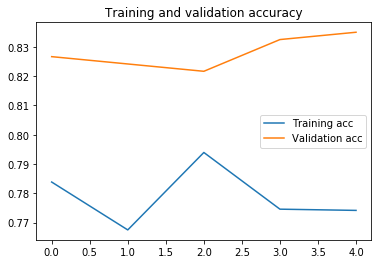

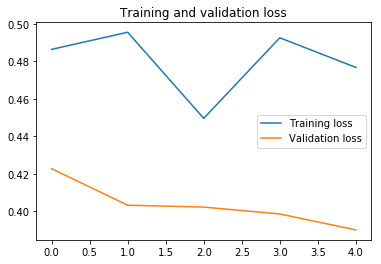

In [53]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()